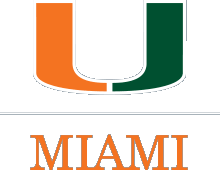
# MPO624 Final Presentation of Learning: Pacific Tropical Cyclones and ENSO
#### Becca Hammersla
#### 5/3/2018

#### Combined first two modules into one notebook

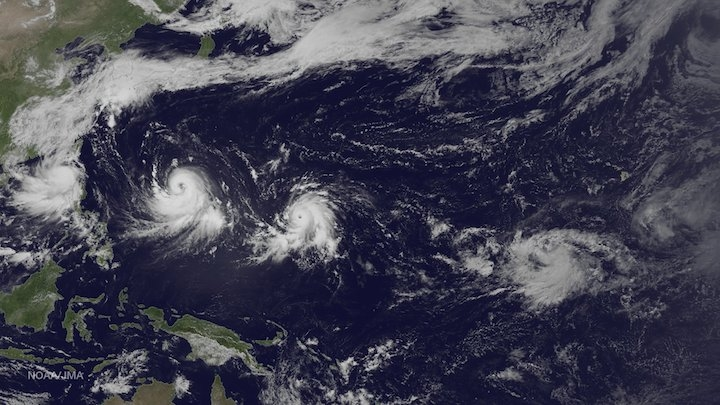

In [2]:
import matplotlib as mpl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
import csv
from IPython.display import display, Math, Latex
from numpy.random import rand
from pylab import rcParams, pcolor, show,colorbar, xticks, yticks, title, figure
from IPython.display import Image
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from scipy import signal
import scipy.stats as stats

In [23]:
# pacific hurricane data from HURDAT study https://github.com/viralthakkar/hurricane-predication
    #1949-2016
# nino data from KNMI climate explorer https://climexp.knmi.nl/data/ienso_li_19492016a.txt
    #1949-2003
# I stuck them together using excel/R because I'm lame and didn't have the time to figure it out with python

file = r'C:\\Users\\rhamm\\Dropbox\\RSMAS\\AppliedDataAnalysis\\patc_days_2.csv'
data = np.genfromtxt(file,delimiter=',',dtype=None,encoding=None,names=True)


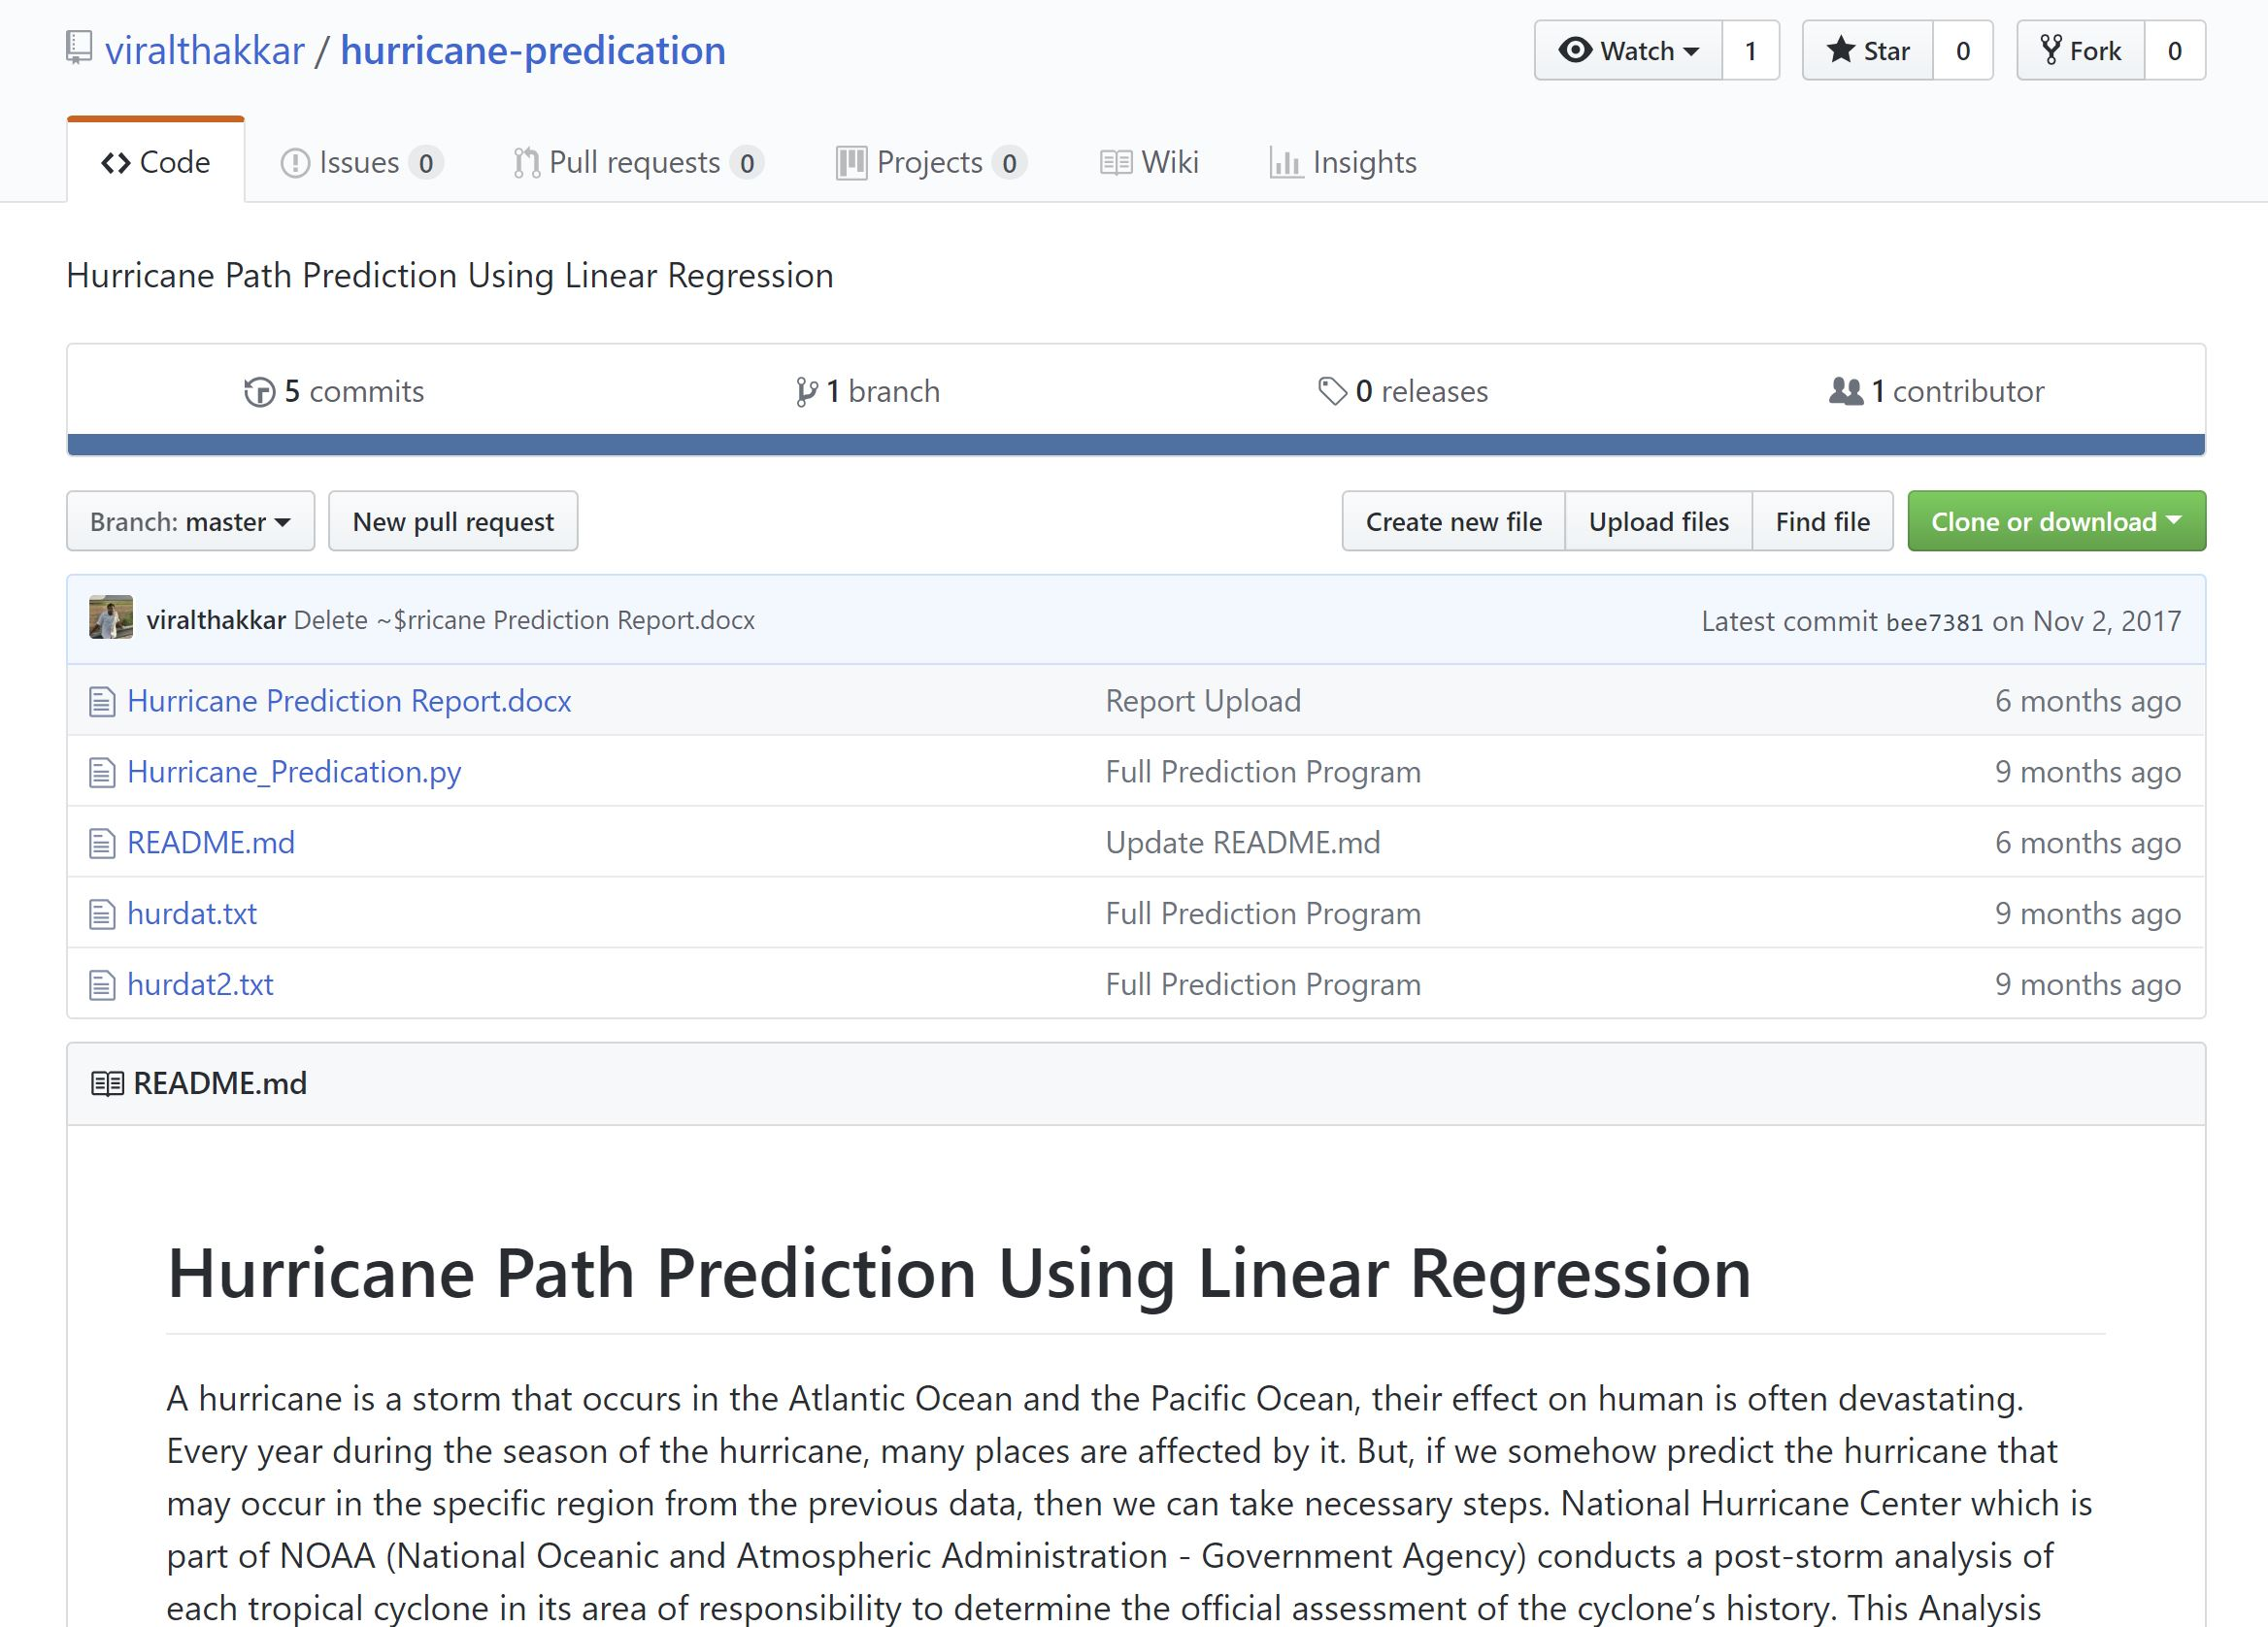

In [24]:
#variables to use

t = data['storm_label']
count = data['location_count'] #"count" is defined by study as number of locations impacted
day = data['day_count']        # i.e. number of times storm was considered "active" for 6 hours
nino = data['nino']            # day count = count/4
storm = data['storm']          # storm = number storm since 1949 (time proxy)


### Begin with plotting data and observing general trends....gotta see the data to formulate a question! A posteriori hypothesis? Yes?

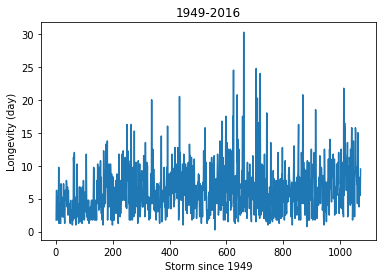

In [5]:
# pacific tc longetivity time series
plt.plot(storm,day)
plt.xlabel('Storm since 1949');plt.ylabel('Longevity (day)');
plt.title('1949-2016');

### Looking like some periodicity? I see 9-10 peaks maybe? Time for lessons from module 2

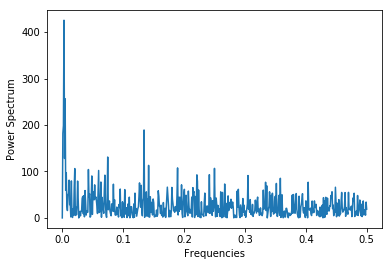

In [6]:
# power spectrum
f, pxx = signal.periodogram(day) #longetivity periodicity
plt.plot(f,pxx)
plt.ylabel('Power Spectrum'); plt.xlabel('Frequencies');

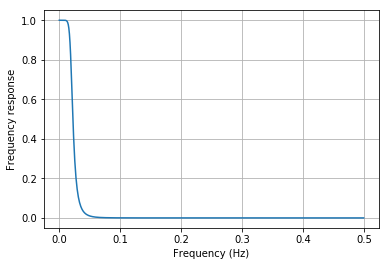

In [7]:
#Identify the dominant frequency and create a low pass filter to remove the seasonality

from scipy.signal import butter, lfilter
from scipy.signal import freqz
import matplotlib.pyplot as plt
nyq=0.5
f=0.02
b, a = butter(5,f/nyq, btype='low')      # low-pass filter, f/nyq to normalize the frequency with Nq;
# b and a are numerator and denominator of IIR filter (Infinite impulse response) as opposed to FIR
w, h = freqz(b, a)
# h is the frequency response and w is the normalized frequencies at which h is calculated

plt.plot((nyq / (1*np.pi)) * w, abs(h))

# abs(h) because h is complex, w is converted back into the sampling frequency to obtain the following plot
plt.xlabel('Frequency (Hz)')
plt.ylabel('Frequency response')
plt.grid(True)

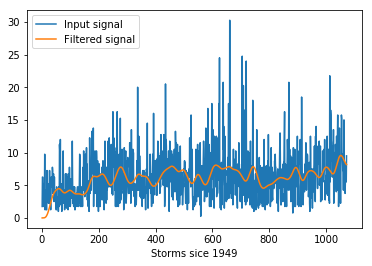

In [8]:
plt.figure()
plt.plot(storm,day, label='Input signal')
y = lfilter(b, a, day)
#lfilter is a causal approach to filter signal only in forward direction, so there is a lag in phase with the original signal
plt.plot(storm, y, label='Filtered signal')
plt.xlabel('Storms sice 1949')
plt.legend(loc='upper left')
plt.show()

### Definitely filtered out a lot of noise and can see clearer peaks

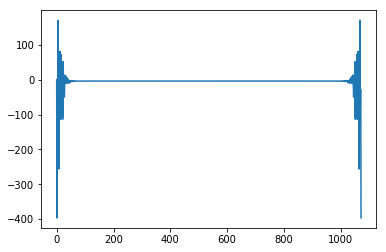

In [9]:
# Take the simple FFT, after removing the mean
# filtered one since non-filtered was did NOT resemble any example 

yp = y - y.mean()

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
yspec = np.fft.fft( yp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(yspec.real)


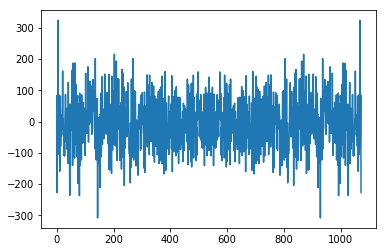

In [26]:
# Take the simple FFT, after removing the mean
# Actually, here's the unfiltered one just in case.....not sure if this looks like anything. 
# I guess I need a better understanding of when it is appropriate to filter before the analysis

dayp = day - day.mean()

# BOOM! Notice there is no time axis, just the values, hence the roll issue above
yspec2 = np.fft.fft( dayp )

# It is symmetric, with low frequencies at BOTH ENDS, except 0 (the mean)
fig,ax=plt.subplots(1,1) 
ax.plot(yspec2.real)

Text(0.5,1,'Unfiltered')

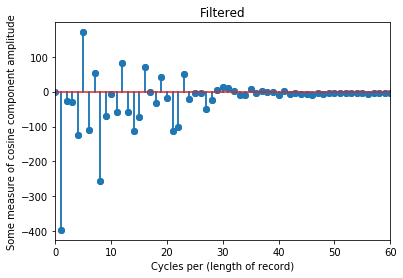

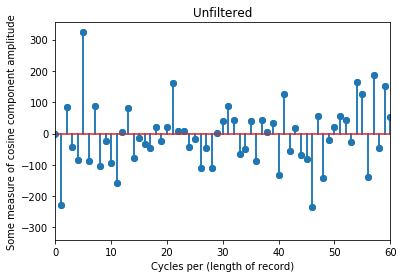

In [15]:
# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
# filtered one

NT = len(storm)
freqs = np.array(range(NT))   # This gets the left end correct
reversed_freqs = freqs[::-1]  # Reverse the array 
reversed_freqs[0:int(NT/2)] = freqs[1:int(NT/2)+1] # Fix the low end of the reversed array
freqs = reversed_freqs[::-1]  # reverse it back 

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, yspec.real)
ax.set_xlim([0,60])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')
ax.set_title('Filtered')

# Define the frequencies "freqs" (noting the symmetry -- but 0 occurs only at left)
# Unfiltered one

fig,ax=plt.subplots(1,1) 
ax.stem(freqs, yspec2.real)
ax.set_xlim([0,60])
ax.set_xlabel('Cycles per (length of record)')
ax.set_ylabel('Some measure of cosine component amplitude')
ax.set_title('Unfiltered')

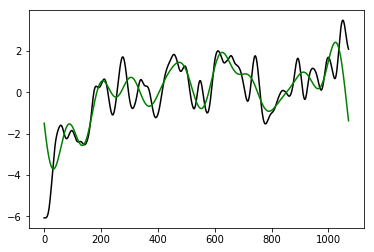

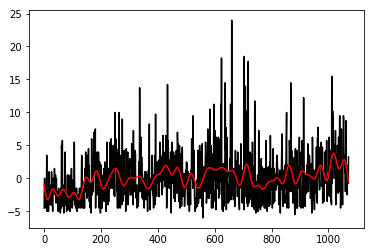

In [20]:
# Mess with the spectrum and reconstruct (a way of filtering)

# Filtered: Truncate the frequencies higher then TRUNC cycles per record length
TRUNC = 10

yspec_trunc = yspec.copy()
yspec_trunc[np.where(freqs > TRUNC)] *= 0. 
yrecon = np.fft.ifft(yspec_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(yp,      color='black')
ax.plot(yrecon,  color='green')

# Unfiltered: Truncate the frequencies higher then TRUNC cycles per record length
# trying out different truncations
TRUNC = 30

yspec2_trunc = yspec2.copy()
yspec2_trunc[np.where(freqs > TRUNC)] *= 0. 
yrecon2 = np.fft.ifft(yspec2_trunc).real

# How's the reconstruction? 
fig,ax=plt.subplots(1,1) 
ax.plot(dayp,      color='black')
ax.plot(yrecon2,  color='red')

### Thinking I'm gonna stop with this filtered/unfiltered business. I suppose the whole point of filtering is to not have all of this useless data that's hard to analyze by just eye balling it. Woah, I think I just learned something! (side note: I definintely was not onboard with "eliminating" data at the start of the class...*gasp* you want me to get rid of perfectly good data? HOW will I explain to non-scientists that I'm NOT manipulating the data to get the result I want)

### Also, that longetivity plot is looking a little trendy towards longer TC activity per storm! SST increase maybe? We'll save that for another time. 

### Let's explore the periodicity relationship to ENSO shall we? There's gotta be a connection with warmer waters to TC longetivity right? I sure think so. 

### Nino year = longer TC?

No handles with labels found to put in legend.
No handles with labels found to put in legend.


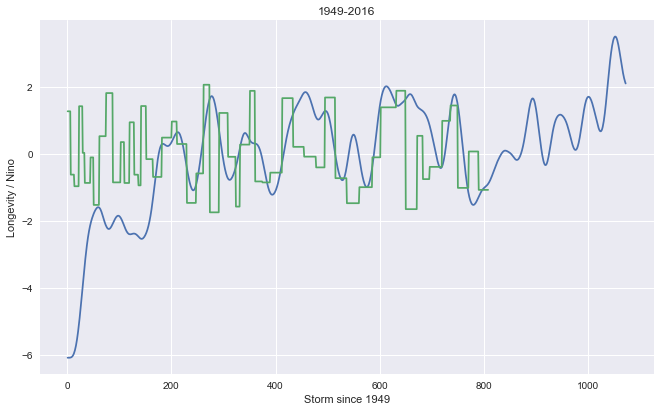

In [15]:
# plot w/ nino index 

#DayNorm = stats.norm.pdf(bins,loc=np.mean(day),scale=np.std(day)) 
#NinoNorm = stats.norm.pdf(bins,loc=np.mean(nino), scale=np.std(nino))
    
    
plt.plot(storm,yp)
plt.xlabel('Storm since 1949');plt.ylabel('Longevity (day)/ Nino');
plt.legend(loc='lower right')
plt.plot(storm,nino)
plt.xlabel('Storm since 1949');plt.ylabel('Longevity / Nino')
plt.legend(loc='lower right')
plt.title('1949-2016');

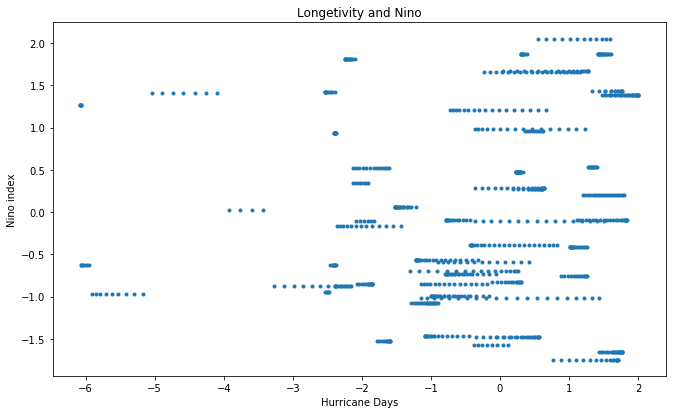

In [13]:
# Define my scatter plot and container
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
rcParams['figure.figsize'] = (11, 6.5)
def fig1():
    fig,ax=plt.subplots(1,1)
    ax.plot(yp,nino,'.')
    ax.set_xlabel('Hurricane Days'); ax.set_ylabel('Nino index')
    ax.set_title('Longetivity and Nino')

fig1()

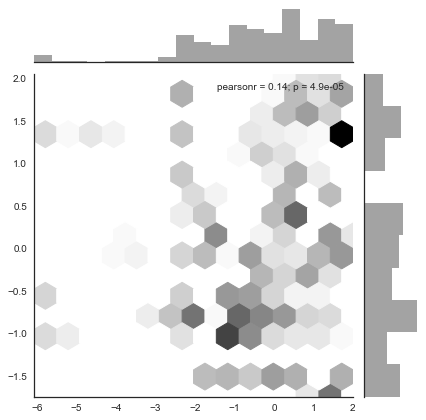

In [14]:
# Do it in Seaborn, with the marginal distributions on the top and side
import seaborn as sns
sns.set(color_codes=True)

df = pd.DataFrame({'x': yp, 'y': nino})
with sns.axes_style("white"):
    sns.jointplot(x=yp, y=nino, kind="hex", color="k");

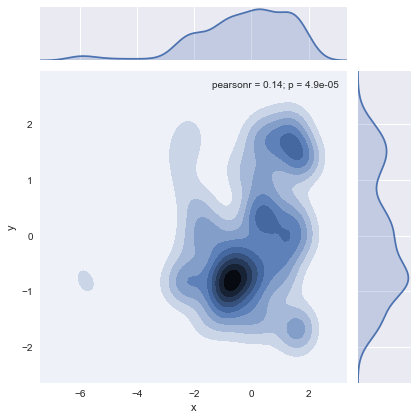

In [51]:
sns.jointplot(x="x", y="y", data=df, kind="kde")

In [18]:
file = r'C:\\Users\\rhamm\\Dropbox\\RSMAS\\AppliedDataAnalysis\\patc_days_tt.csv'
data = np.genfromtxt(file,delimiter=',',dtype=None,encoding=None,names=True)

day = data['day_count']       
nino = data['nino']

In [19]:
#Also did a t-test because why not
stats.ttest_ind(day, nino, axis=0, equal_var=True)

Ttest_indResult(statistic=44.91783939860246, pvalue=1.5966419720141406e-286)

### Went to literature to corroborate findings
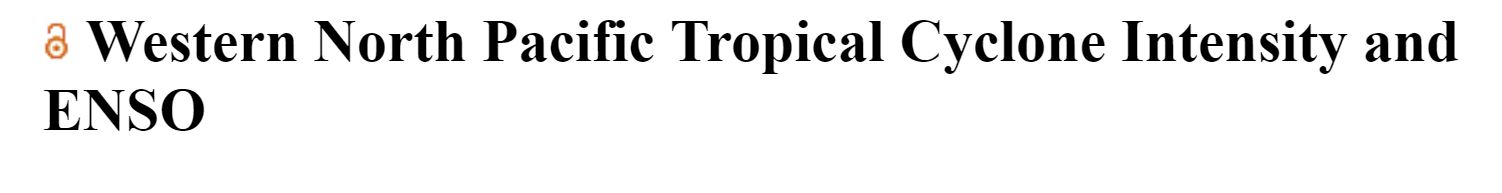
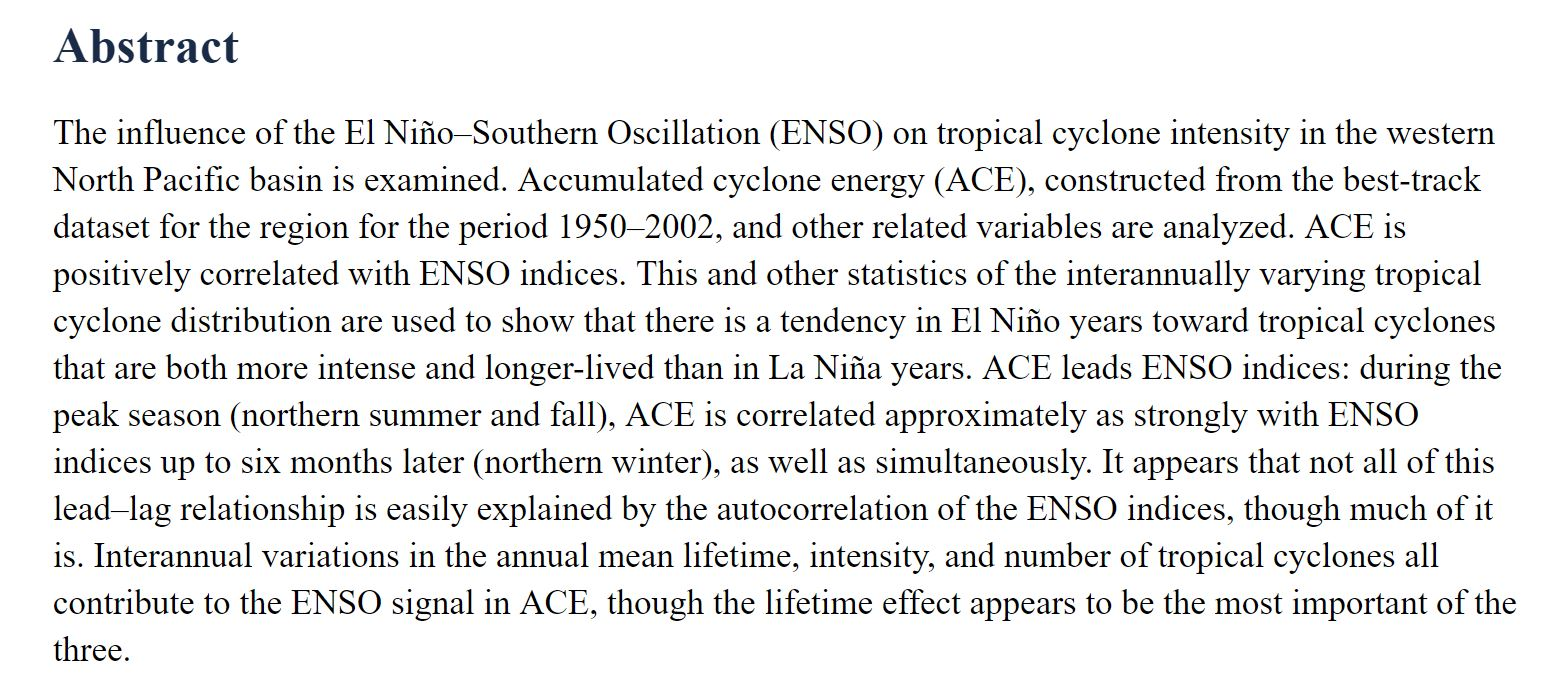
